In [2]:
import os

os.environ["OMP_NUM_THREADS"] = "6" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "6" # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "6" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import matplotlib
import xgboost as xgb
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [13]:
r2s_train, mses_train, maes_train = [], [], []
r2s_test, mses_test, maes_test = [], [], []
r2s_val, mses_val, maes_val = [], [], []

for seed in range(10):
    np.random.seed(seed)
    
    # load NO2 data
    complete_df = pd.read_csv("../data/local_no2_data.csv").drop_duplicates()
    
    scaler = StandardScaler()
    scaler_target = StandardScaler()
    
    # add one-hot encoding
    X = pd.get_dummies(complete_df, columns=["Countrycode", "AreaType", "StationType"], drop_first=False)
    X[["altitude_scaled", "population_density_scaled"]] = pd.DataFrame(scaler.fit_transform(X[["Altitude", "PopulationDensity"]]))
    X["no2_average_scaled"] = scaler_target.fit_transform(X["no2_average"].values.reshape(-1,1))

    X.drop(["AirQualityStation", "Altitude", "PopulationDensity"], axis=1, inplace=True)

    train, test = train_test_split(X, test_size=0.4)
    test, val = train_test_split(test, test_size=0.5)
    
    train_data = xgb.DMatrix(data=train.drop(["no2_average", "no2_average_scaled"], axis=1), label=train.no2_average_scaled)
    test_data = xgb.DMatrix(data=test.drop(["no2_average", "no2_average_scaled"], axis=1), label=test.no2_average_scaled)
    val_data = xgb.DMatrix(data=val.drop(["no2_average", "no2_average_scaled"], axis=1), label=val.no2_average_scaled) 
    
    param = {'eta': 0.4, # from grid search in local_baseline_whole_timespan.ipynb
             'gamma': 1,
             'max_depth': 4,
             'objective': 'reg:squarederror',
             'subsample': 1,
            }
    
    num_round = 50
    bst = xgb.train(param, train_data, num_round)
    
    ypred = scaler_target.inverse_transform(bst.predict(test_data).reshape(-1,1))
    ypred_train = scaler_target.inverse_transform(bst.predict(train_data).reshape(-1, 1))
    ypred_val = scaler_target.inverse_transform(bst.predict(val_data).reshape(-1, 1))
    
    r2_val = r2_score(val.no2_average, ypred_val)
    mse_val = mean_squared_error(val.no2_average, ypred_val)
    mae_val = mean_absolute_error(val.no2_average, ypred_val)
    
    r2_test = r2_score(test.no2_average, ypred)
    mse_test = mean_squared_error(test.no2_average, ypred)
    mae_test = mean_absolute_error(test.no2_average, ypred)
    
    r2_train = r2_score(train.no2_average, ypred_train)
    mse_train = mean_squared_error(train.no2_average, ypred_train)
    mae_train = mean_absolute_error(train.no2_average, ypred_train)
    
    r2s_val.append(r2_val)
    r2s_test.append(r2_test)
    r2s_train.append(r2_train)
    
    mses_val.append(mse_val)
    mses_test.append(mse_test)
    mses_train.append(mse_train)
    
    maes_val.append(mae_val)
    maes_test.append(mae_test)
    maes_train.append(mae_train)
    
    print(f"seed: {seed}")
    print("\t".join(map(str, [r2_test, mae_test, mse_test])))

seed: 0
0.6293527795819569	4.949609954594662	44.59711031588085
seed: 1
0.6417636729095677	5.338815979659962	53.482172347186804
seed: 2
0.6614439835961522	5.118027386387157	47.51341622030381
seed: 3
0.6380831246055962	5.266342993130963	50.62433396935516
seed: 4
0.6683715934439944	4.954969856543429	41.183286581255786
seed: 5
0.6109853796008599	5.2900612168157455	50.64369345248029
seed: 6
0.6828741715700142	5.456379966370645	50.877082052814956
seed: 7
0.6330707572229031	5.116598211304988	46.73526106678595
seed: 8
0.6624206603009539	5.234952535931995	48.66931280699687
seed: 9
0.6847460577415987	5.072836130411295	45.87422902443715


In [14]:
print("R2:", np.array(r2s_test).mean(), "$\pm$", np.array(r2s_test).std())

R2: 0.6513112180573597 $\pm$ 0.023105099752181057


In [15]:
print("MAE:", np.array(maes_test).mean(), "pm", np.array(maes_test).std())

MAE: 5.179859423115085 pm 0.15724477536053058


In [16]:
print("MSE:", np.array(mses_test).mean(), "pm", np.array(mses_test).std())

MSE: 48.019989783749764 pm 3.42132303320401


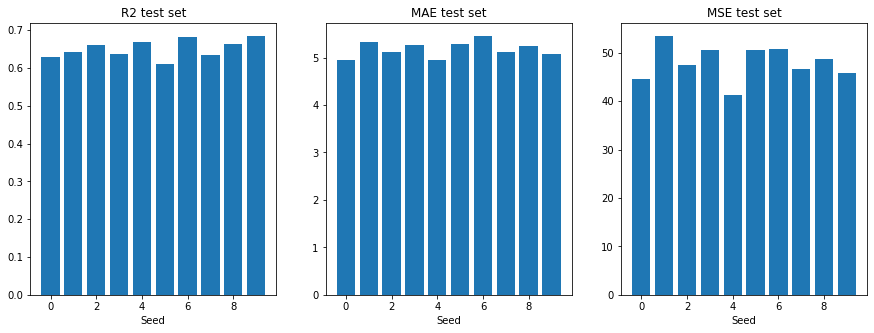

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.bar(range(len(r2s_test)), r2s_test)
ax1.set_title("R2 test set")
ax1.set_xlabel("Seed")

ax2.bar(range(len(maes_test)), maes_test)
ax2.set_title("MAE test set")
ax2.set_xlabel("Seed")

ax3.bar(range(len(mses_test)), mses_test)
ax3.set_title("MSE test set")
ax3.set_xlabel("Seed")

plt.show()

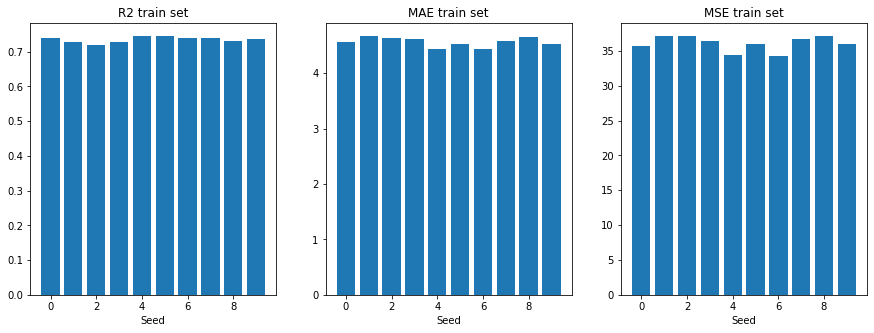

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.bar(range(len(r2s_train)), r2s_train)
ax1.set_title("R2 train set")
ax1.set_xlabel("Seed")

ax2.bar(range(len(maes_train)), maes_train)
ax2.set_title("MAE train set")
ax2.set_xlabel("Seed")

ax3.bar(range(len(mses_train)), mses_train)
ax3.set_title("MSE train set")
ax3.set_xlabel("Seed")

plt.show()

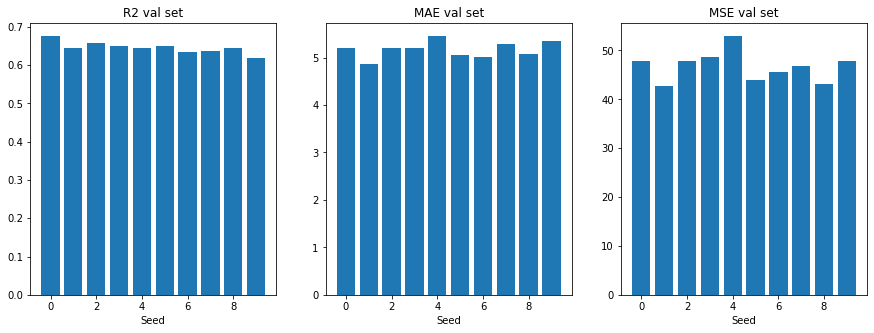

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.bar(range(len(r2s_val)), r2s_val)
ax1.set_title("R2 val set")
ax1.set_xlabel("Seed")

ax2.bar(range(len(maes_val)), maes_val)
ax2.set_title("MAE val set")
ax2.set_xlabel("Seed")

ax3.bar(range(len(mses_val)), mses_val)
ax3.set_title("MSE val set")
ax3.set_xlabel("Seed")

plt.show()